# Focusing Network Test Single Run Test

## This notebook is prepared for "Adaptive Locally Connected Neuron: Focusing Neuron" paper by F. Boray TEK

 * Focusing Network Test Case for Single Run MNIST
 * The network here is very simple two layer network and for demonstration only
 * To obtain large scale tests of the paper refer to mnist.py
 * If running on GOOGLE COLAB, change Runtime type to GPU
 * Requires, focusing.py, data_utils.py, lasagne_utils.py, 
 * ----< If running on GOOGLE COLAB, upload focusing.py, data_utils.py, lasagne_utils.py, plot_utils >----
 


* Code Authors:  F. Boray Tek (İlker Çam contributed to an earlier version)
 
 * For details, see the paper:
 * 
 *  http://arxiv.org/abs/1809.09533
 * 
 *
 * Permission to use, copy, modify, and distribute this software and
 * its documentation for educational, research, and non-commercial
 * purposes, without fee and without a signed licensing agreement, is
 * hereby granted, provided that the above copyright notice and this
 * paragraph appear in all copies modifications, and distributions.
 *
 * NOTE: THIS WORK IS PATENT PENDING!
 * Patent rights are owned by F. Boray Tek, İlker Çam, Işık University
 * Any commercial use or any commercial redistribution of this software
 * requires a license from one of the above mentioned establishments.

 * For further details, contact F. Boray Tek (boraytek@gmail.com).

In [0]:
#!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
#!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

In [2]:
import os
os.environ['THEANO_FLAGS']='device=cuda,floatX=float32,preallocate=0.1'
os.environ['MKL_THREADING_LAYER']='GNU'
import time
import matplotlib.pyplot as plt
import lasagne
import theano
theano.config.exception_verbosity = 'high'
import theano.tensor as T
import numpy as np
from focusing import FocusedLayer1D
from collections import OrderedDict
from lasagne.updates import get_or_compute_grads, apply_momentum, sgd
from lasagne.updates import momentum, adam, adadelta
from lasagne.regularization import regularize_layer_params_weighted, l2, l1
from lasagne.regularization import regularize_layer_params



from lasagne_utils import sgdWithLrsClip,categorical_focal_loss,\
get_shared_by_pattern,sgdWithLrs,iterate_minibatches,set_params_value,\
print_param_stats, get_params_values_wkey,sgdWithWeightSupress

from data_utils import load_dataset_mnist, load_dataset_mnist_cluttered,\
load_dataset_fashion, load_dataset_cifar10

import pandas as pd
#pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)[source]¶
from data_utils import load_blob

/usr/local/lib/python3.6/dist-packages/theano/configdefaults.py:1952: UserWarning: Theano does not recognise this flag: preallocate
  warnings.warn('Theano does not recognise this flag: {0}'.format(key))
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [0]:
%matplotlib inline
import matplotlib
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [0]:
f32 = np.float32

In [0]:
def build_dense_model(input_shape,input_var, fparams):
    # Initers, Layers
    nhidden = fparams['nHIDDEN']
    nclasses = fparams['nCLASSES']
    batchnorm = fparams['USEBATCHNORM']
    use_penalty = fparams['USE_PENALTY']
    ini = lasagne.init.GlorotUniform()
    
    nonlin = lasagne.nonlinearities.rectify
    softmax = lasagne.nonlinearities.softmax
    
    lin = lasagne.nonlinearities.linear
    
    # Input Layer
    l_in = lasagne.layers.InputLayer(shape=input_shape, input_var=input_var)
    
    # Denses
    l_dense1 = lasagne.layers.DenseLayer(
            l_in, num_units=nhidden, 
            nonlinearity=lin, 
            W=ini, name="dense1")
    
    
    if batchnorm:
    # if you close BATCHNORM weights get LARGE
        l_bn = lasagne.layers.NonlinearityLayer(
                lasagne.layers.BatchNormLayer(l_dense1), nonlinearity=nonlin)
    
    else:
    
        l_bn = lasagne.layers.NonlinearityLayer(l_dense1, nonlinearity=nonlin)
    #l_dense2 = lasagne.layers.DenseLayer(l_dense1, num_units=4, nonlinearity=lasagne.nonlinearities.tanh, W=ini, name='dense2')
    
    #l_drop1 = lasagne.layers.dropout(l_bn, p=0.1)
    
    # Output Layer
    l_out = lasagne.layers.DenseLayer(l_bn, num_units=nclasses, nonlinearity=softmax, W=ini, name='output')
    
    
    penalty = l2(l_dense1.W)*1e-5+l2(l_out.W)*1e-5
    if not use_penalty:
        penalty = penalty*0
    
    #penalty = penalty*0
    #penalty = (l2(l_dense1.W)*1e-30)#(l2(l_dense1.W)*1e-3)+(l1(l_dense1.W)*1e-6) +(l2(l_out.W)*1e-3)
    
    return l_out, penalty

In [0]:
def build_focused_model(input_shape,input_var, fparams):
    # Initers, Layers
    
    nhidden = fparams['nHIDDEN']
    nclasses = fparams['nCLASSES']
    batchnorm = fparams['USEBATCHNORM']
    use_penalty = fparams['USE_PENALTY']
    
    ini = lasagne.init.GlorotUniform()
    nonlin = lasagne.nonlinearities.rectify
    linear = lasagne.nonlinearities.linear
    softmax = lasagne.nonlinearities.softmax

    
    # Input Layer
    l_in = lasagne.layers.InputLayer(shape=input_shape, input_var=input_var)
    
    l_focus1 = FocusedLayer1D(l_in, num_units=nhidden, 
                              nonlinearity=linear, name='focus1',
                              trainMus=fparams['trainMus'],
                              trainSis=fparams['trainSis'],
                              initMu=fparams['initMu'], 
                              W=ini, withWeights=fparams['withWeights'], 
                              bias=lasagne.init.Constant(f32(0.0)), 
                              initSigma=fparams['initSigma'], 
                              trainWs=fparams['trainWs'])
                                               
    
    if batchnorm:
    # if you close BATCHNORM weights get LARGE
        l_bn = lasagne.layers.NonlinearityLayer(
                lasagne.layers.BatchNormLayer(l_focus1), nonlinearity=nonlin)
    
    else:
    
        l_bn = lasagne.layers.NonlinearityLayer(l_focus1, nonlinearity=nonlin)
 
    #l_drop1 = lasagne.layers.dropout(l_bn, p=0.1)
    
    # Output
    l_out = lasagne.layers.DenseLayer(l_bn, num_units=nclasses, 
                                      nonlinearity=softmax, W=ini, name='output')
    
    penalty = l2(l_out.W)*f32(1e-5)
    # if focusing neuron has weights. add penalty to them as well. A 10th factors less because focus function already suppresses weghts
    if fparams['withWeights']:
        penalty += l2(l_focus1.W)*f32(1e-5)
    
    if not use_penalty:
        penalty = penalty*0
    
    
    return l_out, penalty

In [0]:
# Compile train and eval functions
def build_functions(using_model, X, y, fparams, penalty):
    

    # training output
    output_train = lasagne.layers.get_output(using_model, X, deterministic=False)

    # evaluation output. Also includes output of transform for plotting
    output_eval = lasagne.layers.get_output(using_model, X, deterministic=True)
    
    cost_train = T.mean(lasagne.objectives.categorical_crossentropy(output_train, y)) + penalty # Regularization
    cost_eval = T.mean(lasagne.objectives.categorical_crossentropy(output_eval, y))
  
    network_params = lasagne.layers.get_all_params(using_model, trainable=True)
    print("Params",network_params)
    n_params =  lasagne.layers.count_params(using_model)
    print("Param count:",n_params)
    
    LR_rate = theano.shared(np.float32(fparams['LEARNING_RATE']),name='lr_all')
    LR_MU = theano.shared(np.float32(fparams['LR_MU']),name='lr_mu')
    LR_SI = theano.shared(np.float32(fparams['LR_SI']),name='lr_si')
    LR_FW = theano.shared(np.float32(fparams['LR_FW']),name='lr_fw')
    LR_params = [LR_rate, LR_MU, LR_SI, LR_FW]
        
    updates = sgdWithLrsClip(cost_train, network_params, learning_rate=LR_rate, 
                         mu_lr=LR_MU, si_lr=LR_SI, 
                         focused_w_lr=LR_FW, momentum=fparams['MOMENTUM'])
    

    
    test_acc = T.mean(T.eq(T.argmax(output_eval, axis=1), y), dtype=theano.config.floatX)

    trainf = theano.function([X, y], [cost_train, output_train, penalty], updates=updates, allow_input_downcast=True, name='train')
    evalf = theano.function([X, y], [cost_eval, output_eval, test_acc], allow_input_downcast=True, name='eval')
    
    
    return trainf, evalf, n_params

In [0]:
# Epoch tranining with mini-batch
def epoch_func(X, y, fnc, penalty=False, batch_size=512):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(batch_size)))
    costs = []
    correct = 0
    penalties = []
    for i in range(num_batches):
        idx = range(i*batch_size, np.minimum((i+1)*batch_size, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        outputs = fnc(X_batch, y_batch)
        costs += [outputs[0]]
        probs = outputs[1]
        preds = np.argmax(probs, axis=1)
        correct += np.sum(y_batch == preds)
        #print("corr:",correct)
        if fnc.name.startswith('train'):
            if penalty:
                penalties += [outputs[2]]
                
    acc = correct/float(num_samples)
    pen = []
    if len(penalties)>0:
        pen = np.mean(penalties)
    
    return np.mean(costs), acc , pen 

## EXPERIMENT SETTINGS 

In [0]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
EXPERIMENT_ID = ""
RANDSEED = 10
from plot_utils import save_fig, paper_fig_settings
paper_fig_settings()

from  datetime import datetime
now = datetime.now()
timestr = now.strftime("%Y%m%d-%H%M%S")
logdir =  os.path.join(PROJECT_ROOT_DIR, "outputs", 
                        CHAPTER_ID+EXPERIMENT_ID)


lasagne.random.set_rng(np.random.RandomState(RANDSEED))  # Set random state so we can investigate results
np.random.seed(RANDSEED)
np.set_printoptions(formatter={'float': '{: 0.4f}'.format}, suppress=True)

PLOT_INT_RESULTS = False
PRINT_INTERVAL = 10
RECORD_INTERVAL= 1

In [10]:
print(CHAPTER_ID+EXPERIMENT_ID)

In [11]:
# config settings for Focusing Layers
Focusing_layer_params={}
Focusing_layer_params['trainSis'] = True
Focusing_layer_params['trainMus'] = True    
Focusing_layer_params['trainWs'] = True
Focusing_layer_params['withWeights'] = True
Focusing_layer_params['initMu'] = 'middle_random'# 'middle' Or sth else
#Focusing_layer_params['initMu'] = 'spread'# 'middle' Or sth else
Focusing_layer_params['initSigma'] = 0.1
print(Focusing_layer_params)

{'trainSis': True, 'trainMus': True, 'trainWs': True, 'withWeights': True, 'initMu': 'middle_random', 'initSigma': 0.1}


In [12]:
# Hyper Parameter Test SETS
NUM_EPOCHS = 100
#dset_choice = #'Mnist','Cifar10'
dset_choice = 'Mnist'


Training_Params = {}
Training_Params['BATCH_SIZE'] = 0.05 # portion of training data
Training_Params['MOMENTUM'] = f32(0.9) # .9 is slightly worse
Training_Params['LEARNING_RATE'] = f32(0.01) # works good. 0.001 is too low for many datasets. 

Network_Params = {}
Network_Params['USEBATCHNORM'] = True #False is 2x 3x times faster, and performance is worse
Network_Params['USE_PENALTY'] = True  # No significant difference perhaps due to low number of epochs
Network_Params['nHIDDEN'] = 40


# this method chooses random values from a list of arrays
def choose_rand(x):
    val=[]
    for k in range(len(x)):
        v = np.random.choice(x[k])
        
        val.append(v)
    return val


def set_lr_rates(d):
    lr_all =d['LEARNING_RATE']    
    lr_fw = lr_all
    INIT_SIGMA = d['initSigma']
    #lr_tr_coeff = 39.08*np.exp(-20.65*INIT_SIGMA)+1.16
    lr_tr_coeff = 1.0
    print(lr_tr_coeff)
    lr_mu = lr_fw/lr_tr_coeff
    lr_si = lr_mu*0.82
    d['LR_MU']= np.float32(lr_mu)
    d['LR_SI'] = np.float32(lr_si)
    d['LR_FW'] = np.float32(lr_all)
    
# combine parameters

pars ={}
pars.update(Training_Params)
pars.update(Network_Params)
pars.update(Focusing_layer_params)
set_lr_rates(pars)
lr_dict = {'all':0.1,
                   'focus-1/Sigma:0': 0.01,'focus-1/Mu:0': 0.01,'focus-1/Weights:0': 0.1,
                   'focus-2/Sigma:0': 0.01,'focus-2/Mu:0': 0.01,'focus-2/Weights:0': 0.1}

print(pars)

1.0
{'BATCH_SIZE': 0.05, 'MOMENTUM': 0.9, 'LEARNING_RATE': 0.01, 'USEBATCHNORM': True, 'USE_PENALTY': True, 'nHIDDEN': 40, 'trainSis': True, 'trainMus': True, 'trainWs': True, 'withWeights': True, 'initMu': 'middle_random', 'initSigma': 0.1, 'LR_MU': 0.01, 'LR_SI': 0.0082, 'LR_FW': 0.01}


In [13]:
#@markdown  FUNCTIONS FOR MNIST DATA (REQUIRES KERAS)
from keras.datasets import mnist


def standarize_image_025(trn, val=None, tst=None):

    trn = trn.astype('float32')
    M = np.float32(255.0)
    K= np.float32(1.0) # to make variance close to 1.0
    trn /= M
    x_mean = np.mean(trn, axis=0)
    trn -=x_mean
    trn *=K
    if val is not None:
        val = val.astype('float32')
        val /= M       
        val -= x_mean
        val*=K
    if tst is not None:
        tst = tst.astype('float32')
        tst /= M
        tst -= x_mean
        tst *=K
    
    return trn, val, tst

def add_noise_to_2D_data(X, scale=0.2,typ="random"):
  # this function takes an image dataset in the shape :,w,h and adds noise
  # noise is padded on the edges of the frame, 
  # images are resized to [w*scale, h*scale]
  
  # input must be three dimensional i, w, h
  w, h = X.shape[1:]
  n = X.shape[0]
  nw,nh = w+int(w*scale), h+int(h*scale)
  x_offset, y_offset=int(w*scale/2), int(h*scale/2)
  vr = np.var(X)
  mn = np.mean(X)
  print(vr,mn)
  if typ=="random":
    base = np.random.normal(loc=mn, scale=np.sqrt(vr)*0.2, size=(n,nw,nh))
  else:
    base = np.zeros(shape=(n,nw,nh))+mn
      
  print(base.shape)
  base[:,x_offset:w+x_offset, y_offset:h+y_offset] = X[:,:,:]
  
  return f32(base)

Using TensorFlow backend.


In [14]:
# prepare data set here. 
if dset_choice=='Mnist':
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    print("Loaded data feature shape", x_train.shape)
    print("Loaded data target shape", y_train.shape)
    
    n_features = x_train.shape[1] 
    pars['BATCH_SIZE'] = 512
    pars['nCLASSES'] = 10
    n_channels =1 
    
    
    
    #@markdown ### Do you want to add noise to mnist data? 
    add_noise_to_data = False #@param {type:"boolean"}
    #@markdown ### Do you want to standardize mnist data? 
    standardize_data = True #@param {type:"boolean"}
    #@markdown ### What type of noise random, constant?:
    noise_type = "random" #@param ["random", "constant"] {type:"string"}
    
    if add_noise_to_data:
        mod_X_tr = add_noise_to_2D_data(x_train, scale=0.3, typ=noise_type)
        mod_X_tst = add_noise_to_2D_data(x_test, scale=0.3,typ=noise_type)
    else:
        mod_X_tr = x_train
        mod_X_tst = x_test
  
    if standardize_data:
        mod_X_tr,_,mod_X_tst = standarize_image_025(mod_X_tr, tst=mod_X_tst)
        x_train, _, x_test = mod_X_tr, _, mod_X_tst
    
    img_rows, img_cols = mod_X_tr.shape[1],mod_X_tr.shape[2]
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_channels)
    X_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_channels)
    input_shape = (None, img_rows, img_cols, n_channels)
    X = T.tensor4('inputs')
    y = T.ivector('targets')
    
    
print(pars)
print("Train data: ",X_train.shape,y_train.shape ,X_train[0].dtype)
print("Test data: ",X_test.shape,y_test.shape,X_train[0].dtype )



Loaded data feature shape (60000, 28, 28)
Loaded data target shape (60000,)
{'BATCH_SIZE': 512, 'MOMENTUM': 0.9, 'LEARNING_RATE': 0.01, 'USEBATCHNORM': True, 'USE_PENALTY': True, 'nHIDDEN': 40, 'trainSis': True, 'trainMus': True, 'trainWs': True, 'withWeights': True, 'initMu': 'middle_random', 'initSigma': 0.1, 'LR_MU': 0.01, 'LR_SI': 0.0082, 'LR_FW': 0.01, 'nCLASSES': 10}
Train data:  (60000, 28, 28, 1) (60000,) float32
Test data:  (10000, 28, 28, 1) (10000,) float32


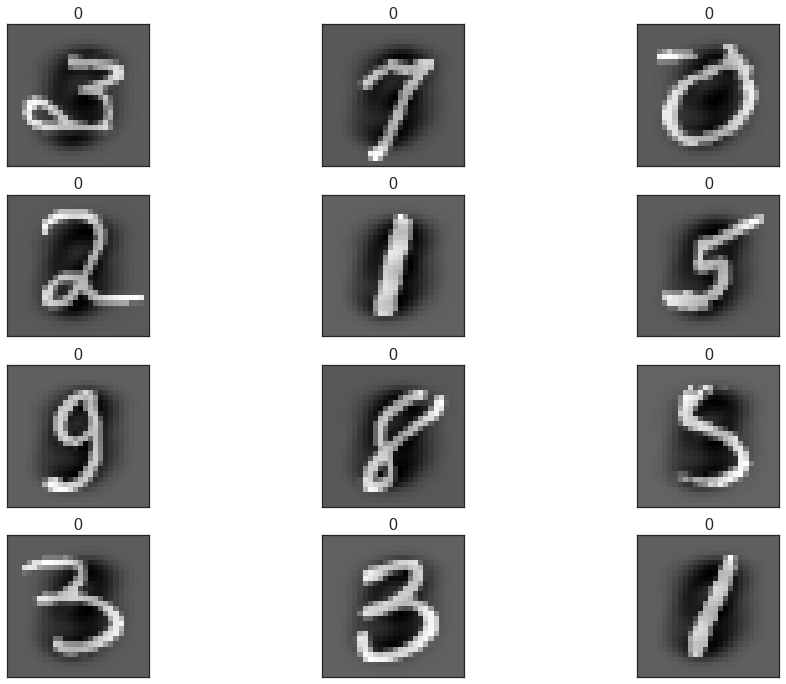

training examples


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
n_example_to_show = 12  #@param {type: "number"}
plt_train_examples=True
show_test = False
ntr = mod_X_tr.shape[0]
ntst = mod_X_tst.shape[0]
sh,sw= 4,int(n_example_to_show/4)

to_show = mod_X_tr
to_target= y_train
if show_test:
  to_show= mod_X_tst
  to_target= y_test
 
if plt_train_examples:
  plt.figure(figsize=(4*sh,4*sw))
  
  for i in range(n_example_to_show):
    k = np.random.randint(ntr)
    plt.subplot(sh,sw,i+1),plt.imshow(to_show[k].reshape((img_rows,img_cols)),'gray')
    plt.title(str(np.argmax(to_target[k])))
    plt.xticks([]),plt.yticks([])


plt.show()
print('training examples')  

In [16]:
model_dense, penalty_dense = build_dense_model(input_shape,X, pars)
mp_dense = lasagne.layers.get_all_params(model_dense, trainable=True)


model_focus, penalty_focus = build_focused_model(input_shape,X,  pars)
mp_focus = lasagne.layers.get_all_params(model_focus, trainable=True)
l_focused = next(l for l in lasagne.layers.get_all_layers(model_focus) if l.name is 'focus1')


train_dense, eval_dense,n_netparamsd = build_functions(model_dense,X,y, pars,  penalty_dense)
train_focus, eval_focus,n_netparamsf = build_functions(model_focus,X,y, pars, penalty_focus)
pars['n_netparamsd'] = n_netparamsd
pars['n_netparamsf'] = n_netparamsf

print(pars)

Params [dense1.W, dense1.b, beta, gamma, output.W, output.b]
Param count: 31970


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
W0805 15:18:00.316912 139978679596928 blas.py:433] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Params [focus1.mu, focus1.si, focus1.W, focus1.bias, beta, gamma, output.W, output.b]
Param count: 32090
{'BATCH_SIZE': 512, 'MOMENTUM': 0.9, 'LEARNING_RATE': 0.01, 'USEBATCHNORM': True, 'USE_PENALTY': True, 'nHIDDEN': 40, 'trainSis': True, 'trainMus': True, 'trainWs': True, 'withWeights': True, 'initMu': 'middle_random', 'initSigma': 0.1, 'LR_MU': 0.01, 'LR_SI': 0.0082, 'LR_FW': 0.01, 'nCLASSES': 10, 'n_netparamsd': 31970, 'n_netparamsf': 32090}


In [0]:
# create utility functions

l_dense = next(l for l in lasagne.layers.get_all_layers(model_dense) if l.name is "dense1")
dense_weights = l_dense.W

l_focused = next(l for l in lasagne.layers.get_all_layers(model_focus) if l.name is 'focus1')

# create functions to read mu, si, and weight values.
get_si = lambda: l_focused.si.get_value()
get_mu = lambda: l_focused.mu.get_value()
get_foci = lambda: l_focused.calc_u().eval().T
get_w = lambda: l_focused.W.get_value()
set_w = lambda value: l_focused.W.set_value(value)


# create output functions to read output of focus layer

output_focus = lasagne.layers.get_output(l_focused, X, deterministic=True)
eval_output_focus = theano.function([X], [output_focus], allow_input_downcast=True)
    
output_dense = lasagne.layers.get_output(l_dense, X, deterministic=True)
eval_output_dense = theano.function([X], [output_dense], allow_input_downcast=True)

In [18]:
# now do the training and test then record the outputs

total_time_focus = 0
total_time_dense = 0
costs_dense, costs_focus = [], []
costs_tst_dense, costs_tst_focus = [], []
accs_dense, accs_focus = [], []

focus_outputs = []
dense_weights = []
mus = []
sis = []
foci = []
w_change = []
scalers = []
#np.random.shuffle(X_test)

test_subset = X_test[np.random.permutation(X_test.shape[0])[0:500],:]
try:
    for n in range(NUM_EPOCHS):
        
        
        if n == 0 or n%RECORD_INTERVAL==0: 
            mus.append(get_mu())
            sis.append(get_si())
            foci.append(get_foci()*get_w())
            w_change.append(get_w())
            
            focus_output = eval_output_focus(test_subset)
            focus_outputs.append(focus_output)
            
        #print("w:",np.asarray(get_w())[:,0], "mu: ",get_mu()[0],"si: ",get_si()[0])
        start_time = time.time()
        train_cost_dense, train_acc_dense, penalty_dense = epoch_func(X_train, 
                                                                      y_train, 
                                                                      train_dense,
                                                                      penalty=pars['USE_PENALTY'],
                                                                      batch_size=pars['BATCH_SIZE'])
        time_spent_dense = time.time() - start_time
        total_time_dense +=time_spent_dense
        
        start_time = time.time()
        train_cost_focus, train_acc_focus, penalty_focus = epoch_func(X_train, 
                                                                      y_train, 
                                                                      train_focus,
                                                                      penalty=pars['USE_PENALTY'],
                                                                      batch_size=pars['BATCH_SIZE'])
        time_spent_focus = time.time() - start_time
        total_time_focus +=time_spent_focus
    
        tst_cost_dense, acc_dense,_= epoch_func(X_test, y_test, eval_dense)
        tst_cost_focus, acc_focus,_ = epoch_func(X_test, y_test, eval_focus)
        
        if not penalty_dense:
            penalty_dense = 0 
        if not penalty_focus:
            penalty_focus = 0 
        if np.mod(n, PRINT_INTERVAL) == 0:
            print(("Dense Ep {0}: Tcst {1:1.5f}, Tacc {2:1.3f}, " +
            "Vcst {3:1.5f}, Vacc {4:3.3f}, Pen: {5:1.5f}," +
            "Time: {6:1.4f}").format(n, train_cost_dense, train_acc_dense,tst_cost_dense,acc_dense, penalty_dense, time_spent_dense))
            print(("Focus Ep {0}: Tcst {1:1.5f}, Tacc {2:1.3f}, " +
            "Vcst {3:1.5f}, Vacc {4:3.3f}, Pen: {5:1.5f}," +
            "Time: {6:1.4f}").format(n, train_cost_focus, train_acc_focus,tst_cost_focus,acc_focus, penalty_focus,time_spent_focus))
            
            
        costs_dense.append(train_cost_dense)
        costs_focus.append(train_cost_focus)
    
        costs_tst_dense.append(tst_cost_dense)
        costs_tst_focus.append(tst_cost_focus)
    
        accs_focus.append(acc_focus)
        accs_dense.append(acc_dense)
        
except KeyboardInterrupt:
    pass

acc_focus_np = np.array(accs_focus)
acc_dense_np = np.array(accs_dense)

Dense Ep 0: Tcst 0.78565, Tacc 0.791, Vcst 0.39107, Vacc 0.901, Pen: 0.00100,Time: 0.5416
Focus Ep 0: Tcst 0.86820, Tacc 0.759, Vcst 0.44633, Vacc 0.890, Pen: 0.00098,Time: 1.1940
Dense Ep 10: Tcst 0.15668, Tacc 0.958, Vcst 0.16077, Vacc 0.954, Pen: 0.00136,Time: 0.5792
Focus Ep 10: Tcst 0.15839, Tacc 0.957, Vcst 0.15962, Vacc 0.955, Pen: 0.00137,Time: 1.0270
Dense Ep 20: Tcst 0.10666, Tacc 0.972, Vcst 0.12709, Vacc 0.963, Pen: 0.00155,Time: 0.5446
Focus Ep 20: Tcst 0.10927, Tacc 0.971, Vcst 0.12368, Vacc 0.964, Pen: 0.00156,Time: 0.9911
Dense Ep 30: Tcst 0.08044, Tacc 0.980, Vcst 0.11375, Vacc 0.967, Pen: 0.00171,Time: 0.5525
Focus Ep 30: Tcst 0.08387, Tacc 0.978, Vcst 0.10923, Vacc 0.969, Pen: 0.00172,Time: 0.9943
Dense Ep 40: Tcst 0.06326, Tacc 0.985, Vcst 0.10903, Vacc 0.969, Pen: 0.00185,Time: 0.5709
Focus Ep 40: Tcst 0.06708, Tacc 0.984, Vcst 0.10237, Vacc 0.969, Pen: 0.00185,Time: 1.0035
Dense Ep 50: Tcst 0.05107, Tacc 0.989, Vcst 0.10810, Vacc 0.969, Pen: 0.00198,Time: 0.5505
F

In [0]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


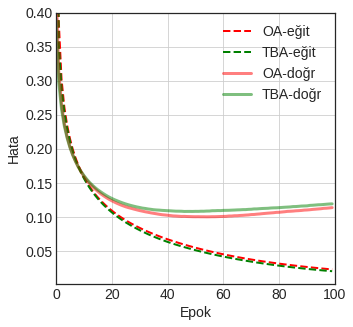

In [20]:
plt.figure(figsize=(5,5))
#plt.title(u"Loss")
plt.plot(np.array(costs_focus), linestyle='--',color='r', linewidth=2)
plt.plot(np.array(costs_dense), linestyle='--', color='g', linewidth=2)
plt.plot(np.array(costs_tst_focus), color='r', linewidth=3, alpha=0.5)
plt.plot(np.array(costs_tst_dense), color='g', linewidth=3, alpha=0.5)

#plt.yscale('log')
#plt.grid(True, which='both')
#plt.legend([u'Fcs-trn', u'Dns-trn', u'Fcs-tst',u'Dns-tst'])
plt.legend([u'OA-eğit', u'TBA-eğit', u'OA-doğr',u'TBA-doğr'])


plt.grid(True)
#plt.xlabel('Epoch')
plt.xlabel('Epok')
#plt.ylabel('Error')
plt.ylabel('Hata')
plt.xlim(0,len(costs_focus))
plt.ylim(0.001,.4)
#save_fig('focus_train')
#save_fig('training_val_loss_synthetic', postfix="")
plt.show()


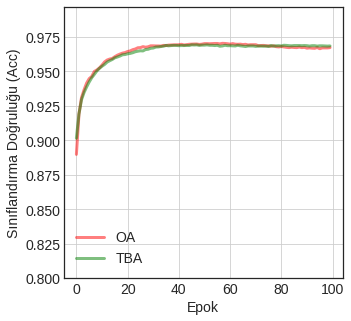

In [21]:
acc_focus_np = np.array(accs_focus)
acc_dense_np = np.array(accs_dense)
plt.figure(figsize=(5,5))
#plt.title(u'Doğrulama Kümesi Doğruluk')
plt.plot(np.array(acc_focus_np), color='r', linewidth=3, alpha=0.5)
plt.plot(np.array(acc_dense_np), color='g', linewidth=3, alpha=0.5)
plt.legend([u'OA', u'TBA'])
#plt.legend([u'Focused', u'Dense'])
#save_fig('focus_acc')
plt.xlabel('Epok')
plt.ylabel(u'Sınıflandırma Doğruluğu (Acc)')
plt.grid(True)
plt.ylim([0.8,0.997])
#save_fig('val_accuracy_synth',postfix=CHAPTER_ID+EXPERIMENT_ID)
plt.show()
#savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#          orientation='portrait', papertype=None, format=None,
#          transparent=False, bbox_inches=None, pad_inches=0.1,
#          frameon=None, metadata=None)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


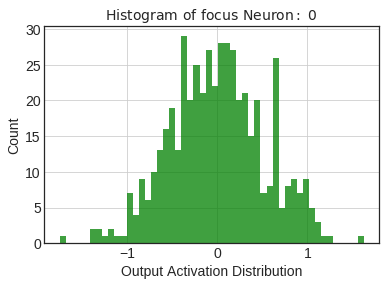

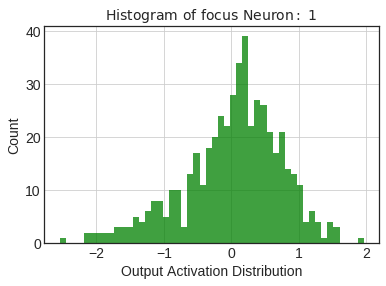

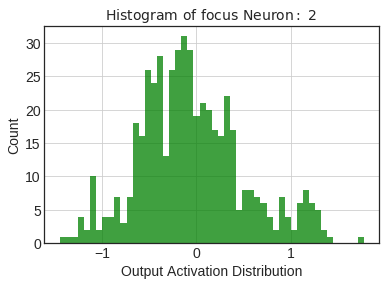

In [22]:
focus_outputs_np = np.array(focus_output).reshape((-1, pars['nHIDDEN']))
for i in range(3):
    x = focus_outputs_np[:, i]
    n, bins, patches = plt.hist(x, 50, normed=0, facecolor='green', alpha=0.75)

    plt.xlabel('Output Activation Distribution')
    plt.ylabel('Count')
    plt.title(r'$\mathrm{Histogram\ of\ focus\ Neuron:}\ '+ str(i) +'$')
    plt.grid(True)
    plt.show()

(100, 40)


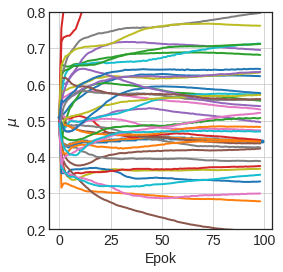

In [23]:
import itertools
markers = itertools.cycle((',', '+', '.', '^', '*')) 
styler = itertools.cycle(('-', '--', '-.')) 

mu = np.array(mus)
print (mu.shape)

plt.figure(figsize=(4, 4))
#plt.title(r'Foci center change')
#plt.xlabel('Epoch')
plt.xlabel('Epok')
plt.ylabel(r'$\mu$')
plt.ylim([0.2,0.8])

#plt.title(r'$\mu$' + u' Değisimi')
#plt.xlabel('Epok')
#plt.ylabel(r'$\mu$')

plt.plot(mu[:, 0] , marker='.')
for x in range(mu.shape[1]):
    plt.plot(mu[0:-1, x],linewidth=2)
plt.grid(True)
#plt.xlim((-100,NUM_EPOCHS))
#plt.xscale('log')
#save_fig('mu_change-mnist',postfix=CHAPTER_ID+EXPERIMENT_ID)
plt.show()


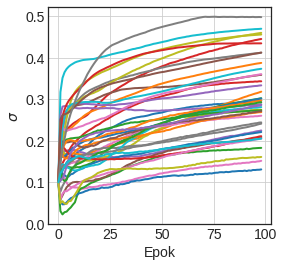

In [24]:
si = np.array(sis)

plt.figure(figsize=(4, 4))
#plt.title(r'$\sigma$' + u' Change')


plt.xlabel('Epok')
plt.ylabel(r'$\sigma$')

#plt.plot(mu[:, 0] * 16, marker='o')
for x in range(si.shape[1]):
    plt.plot(si[0:-1, x],linewidth=2)
plt.grid(True)
#plt.xlim((-100,NUM_EPOCHS))
#plt.xscale('log')
#save_fig('si_change-mnist', postfix=CHAPTER_ID+EXPERIMENT_ID)
plt.show()



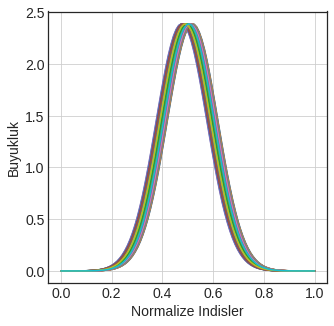

In [25]:
from focusing import U_numeric 
mu = np.array(mus).squeeze()
si = np.array(sis)

mu_initial = mu[0, :]
mu_final = mu[-1, :]
si_initial = si[0, :] # (8 / 16) / (np.repeat(np.sqrt(16 / (8 * 1.0)), 8))
si_final = si[-1, :]

# Print Initial Gaussians
idxs = np.linspace(0, 1., 100)
ex = U_numeric(idxs, mu_initial, si_initial, scaler=1.0)

plt.figure(figsize=(5,5))
#plt.title('Odaklarin Ilk Hali')
for i in range(ex.shape[0]):
    plt.plot(idxs, ex[i, :])  # + idxs to see the overlapping gaussians
plt.grid(True)
plt.ylabel('Buyukluk')
plt.xlabel('Normalize Indisler')
#save_fig('focus-initial-mnist', postfix=CHAPTER_ID+EXPERIMENT_ID)
plt.show()

(40, 128)


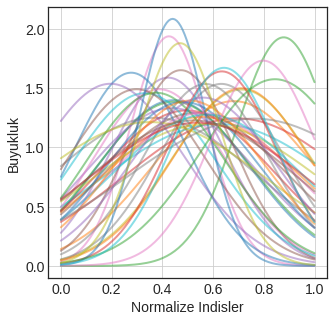

In [26]:
plt.figure(figsize=(5,5))
#plt.plot(idxs, ex[0, :], marker='*', markersize=10)
# Print Final Gaussians
idxs = np.linspace(0, 1., 128)
ex = U_numeric(idxs, mu_final, si_final, scaler=1.0)
print (ex.shape)
for i in range(ex.shape[0]):
    ax = plt.plot(idxs, ex[i, :], alpha=0.5, linewidth=2)
plt.grid(True)
#plt.title('Odaklarin Son Hali')
plt.ylabel('Buyukluk')
plt.xlabel('Normalize Indisler')
#save_fig('focus-after-mnist', postfix=CHAPTER_ID+EXPERIMENT_ID)

plt.show()

(100, 784, 40)


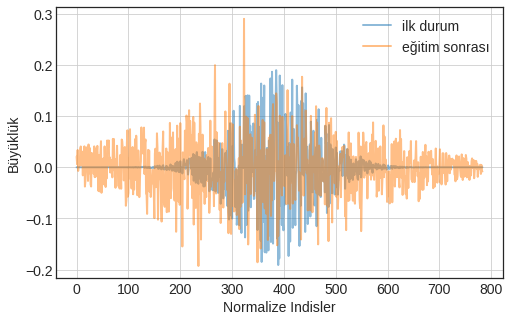

In [27]:
plt.figure(figsize=(8,5))
#plt.plot(idxs, ex[0, :], marker='*', markersize=10)
# Print Final Gaussians
idxs = np.linspace(0, 1., 128)
focused_w = np.array(foci)
print (focused_w.shape)
ax = plt.plot(focused_w[0,:,2], alpha=0.5, linewidth=2)
ax = plt.plot(focused_w[-1,:,2], alpha=0.5, linewidth=2)

plt.grid(True)
#plt.title('Odaklarin Son Hali')
plt.ylabel('Büyüklük')
plt.xlabel('Normalize Indisler')
plt.legend(('ilk durum','eğitim sonrası'))
#save_fig('focused_weights_before_after', postfix=CHAPTER_ID+EXPERIMENT_ID)

plt.show()